In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Learning_Data")

In [3]:
import cv2
#from sklearn.utils import shuffle
from keras.utils import np_utils
import numpy as np

In [4]:
os.listdir()

['Mindy',
 'Iain',
 'Rakul',
 'Shabana',
 'Sidhu',
 'Leonardo',
 'Kerry',
 'Amitabh',
 'Andre',
 'Haley']

In [5]:
parent=r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Learning_Data"
categories=[]
label=0
training=[]
for directory in os.listdir():
  
  categories.append(directory)
  route=os.path.join(parent,directory)
  for img in os.listdir(route):
    image=cv2.imread(os.path.join(route,img))
    image=cv2.resize(image,(400,400))
    training.append([image,label])
  label+=1

In [ ]:
from scipy import ndimage

In [ ]:
#Creating rotated images
for directory in os.listdir():
  route=os.path.join(parent,directory)
  for img in os.listdir(route):
    image=cv2.imread(os.path.join(route,img))
    image=cv2.resize(image,(400,400))
    image_90=ndimage.rotate(image,90)
    filename_90=os.path.join(route,img+"_90.jpg")
    cv2.imwrite(filename_90,image_90)
    image_180=ndimage.rotate(image,180)
    filename_180=os.path.join(route,img+"_180.jpg")
    cv2.imwrite(filename_180,image_180)
    image_270=ndimage.rotate(image,270)
    filename_270=os.path.join(route,img+"_270.jpg")
    cv2.imwrite(filename_270,image_270)



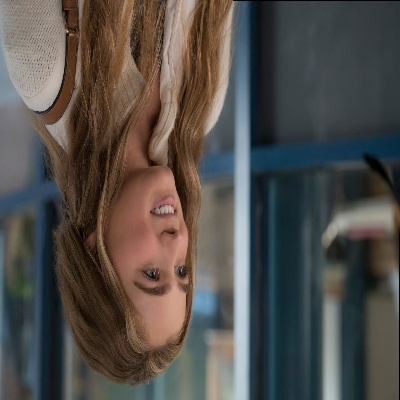

In [6]:
from google.colab.patches import cv2_imshow
cv2_imshow(training[198][0])

In [7]:
X=list()
y=[]
for features,labels in training:
  X.append(features)
  y.append(labels)
X=np.array(X).reshape(-1,400,400,3)
X=X.astype('float32')
X/=255
Y=np_utils.to_categorical(y,10)
Y=np.array(Y)


In [8]:
import tensorflow as tf

In [16]:
def get_sample(num_classes=10,n_support=1,n_query=1):
  sample=[]
  #Choose "num_classes" number of classes randomly from the unique classes. 
  K=np.random.choice(np.unique(y),size=num_classes,replace=False)
  for item in K:
    dataX_item=[]
    item_1=categories[item]
    route=os.path.join(parent,item_1)
    for image in os.listdir(route):
      img=cv2.imread(os.path.join(route,image))
      img=cv2.resize(img,(64,64))
      dataX_item.append(img)
    dataX_item=np.array(dataX_item).reshape(-1,64,64,3)
    dataX_item=dataX_item.astype('float32')
    perm=np.random.permutation(dataX_item)
    sample_cls = perm[:n_support+n_query]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = np.transpose(sample,(0,1,4,2,3))
  sample = tf.convert_to_tensor(sample, dtype=tf.float32)
  return({
      'images': sample,
      'n_way': num_classes,
      'n_support': n_support,
      'n_query': n_query
      })

In [17]:
x=get_sample(10,15,5)

In [18]:
x['images'].shape

TensorShape([10, 20, 3, 64, 64])

In [15]:
'''
Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
'''
class ProtoModel(tf.keras.Model):
  def __init__(self):
    super.__init__()
    self.conv_1 = tf.keras.layers.Conv1D(64,kernel_size=3,padding='same')
    self.bn_1=tf.keras.layers.BatchNormalization()
    self.maxpool_1=tf.keras.layers.MaxPooling2D(2)
    self.conv_2 = tf.keras.layers.Conv1D(64,kernel_size=3,padding='same')
    self.bn_2=tf.keras.layers.BatchNormalization()
    self.maxpool_2=tf.keras.layers.MaxPooling2D(2)
    self.conv_3 = tf.keras.layers.Conv1D(64,kernel_size=3,padding='same')
    self.bn_3=tf.keras.layers.BatchNormalization()
    self.maxpool_3=tf.keras.layers.MaxPooling2D(2)
    self.conv_4 = tf.keras.layers.Conv1D(64,kernel_size=3,padding='same')
    self.bn_4=tf.keras.layers.BatchNormalization()
    self.maxpool_4=tf.keras.layers.MaxPooling2D(2)
    self.flatten=tf.keras.layers.Flatten()

  def call(self,input):
    conv_1_out=self.conv_1(input)
    bn_1_out=self.bn_1(conv_1_out)
    relu1_out=tf.nn.relu(bn_1_out)
    maxpool_1_out=self.maxpool_1(relu1_out)
    conv_2_out=self.conv_2(maxpool_1_out)
    bn_2_out=self.bn_2(conv_2_out)
    relu2_out=tf.nn.relu(bn_2_out)
    maxpool_2_out=self.maxpool_2(relu2_out)
    conv_3_out=self.conv_3(maxpool_2_out)
    bn_3_out=self.bn_3(conv_3_out)
    relu3_out=tf.nn.relu(bn_3_out)
    maxpool_3_out=self.maxpool_3(relu3_out)
    conv_4_out=self.conv_4(maxpool_3_out)
    bn_4_out=self.bn_4(conv_4_out)
    relu4_out=tf.nn.relu(bn_4_out)
    maxpool_4_out=self.maxpool_4(relu4_out)
    output=self.flatten(maxpool_4_out)
    return output
'''

def conv_block(inputs, out_channels, name='conv'):
    with tf.variable_scope(name):
        conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
        conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
        conv = tf.nn.relu(conv)
        conv = tf.contrib.layers.max_pool2d(conv, 2)
        return conv

def encoder(x, h_dim, z_dim, reuse=False):
    with tf.compat.v1.variable_scope('encoder', reuse=reuse):
        net = conv_block(x, h_dim, name='conv_1')
        net = conv_block(net, h_dim, name='conv_2')
        net = conv_block(net, h_dim, name='conv_3')
        net = conv_block(net, z_dim, name='conv_4')
        net = tf.keras.layers.Flatten(net)
        return net
'''
def euclidean_distance(a, b):
    # a.shape = N x D
    # b.shape = M x D
    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    assert D==tf.shape(b)[1]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)


In [ ]:
'''
log_p_y = tf.nn.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
_, y_hat = log_p_y.max(2)
acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()